## Analyzing Feature Importance with mlutils

In this notebook we look at how we can use mlutils to analyze Feature Importance.

Most of these tasks are done through the use of RandomForests in scikit-learn, as they are able to report feature importance. We'll also use scikit-learn to generate synthetic datasets to test our API, which is better than using real datasets because we won't have any predefined notions of what the features mean, and as such, we analyze them without any implicit bias.

The techniques show here work for both Regression and Classification problems

In [59]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [60]:
from mlutils.features import *
from mlutils.models.trees import *
from mlutils.models.classification import *
from mlutils.models.regression import *
from mlutils.plot import *
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
import pandas as pd
import numpy as np
import seaborn

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Dark2')

## Feature Importance using RandomForest

Let's generate a classification dataset with a few significant features

In [61]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=10000,
                           n_features=20,
                           n_informative=3,
                           n_redundant=4,
                           n_repeated=2,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

In [62]:
# setup some columns names
x = np.arange(1, 21)

# Obtain array of square of each element in x
namer = lambda t: f"col{t}"
column_names = np.array([namer(xi) for xi in x])
column_names

array(['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8',
       'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15',
       'col16', 'col17', 'col18', 'col19', 'col20'], dtype='<U5')

In [63]:
# create a pandas dataframe as most of the mlutils functions expect it
df = pd.DataFrame(X, columns = column_names)
df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,1.748267,2.690969,-0.762359,0.035483,-3.398872,-0.449087,0.395920,-3.398872,-3.398872,-0.835943,-0.619195,1.211445,-0.977753,-0.350975,-0.713529,1.245046,-1.492278,-1.642324,-0.216367,-0.410060
1,2.089446,2.897283,-0.347177,-0.315395,-3.319302,-0.383794,0.298654,-3.319302,-3.319302,1.158787,0.319880,-0.717324,0.537883,-0.841434,0.915618,0.381529,0.928201,-0.191589,-1.450351,-1.277512
2,1.359057,1.124433,-0.449752,-0.133905,-1.811808,-0.764300,0.239303,-1.811808,-1.811808,1.104101,0.832162,0.519420,-1.123108,0.002859,0.759708,-0.001906,-0.783813,-0.382345,-0.157327,-0.327187
3,0.942504,-0.076773,0.246008,-0.490059,-0.129660,-0.655792,-0.021506,-0.129660,-0.129660,0.709807,0.493653,0.027510,-1.247057,-1.421111,0.601274,-1.647467,-0.359601,2.528175,-1.887663,0.041040
4,1.076313,1.796803,-1.741340,0.782606,-3.348680,-0.917844,0.621559,-3.348680,-3.348680,-0.179285,-1.430903,-1.063582,-0.621017,0.056493,-0.411359,-1.467355,-1.391466,0.548117,0.308911,-1.093658


In [64]:
# let's create a training and validation set
n_train = int(len(df) * 0.8)
print("n_train:", n_train)

X_train, X_val = split_vals(df, n_train)
y_train, y_val = split_vals(y, n_train)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

n_train: 8000


((8000, 20), (2000, 20), (8000,), (2000,))

In [65]:
# we start by creating a simple RandomForestClassifier to model our data
m = RandomForestClassifier(n_jobs=-1, oob_score=True)
train_classifier(m, X_train, y_train)
predict_and_evaluate_classifier(m, X_val, y_val);

Accuracy (Training): 0.997
          OOB Score: 0.953875
     Accuracy score: 0.89050


Result above shows that we can model our data very well with a RandomTree even though we are overfitting.
In any case, let's look at feature importance

In [66]:
fi = rf_feat_importance(m, df)
fi.reset_index(inplace=True, drop=True)
fi[:10]

,cols,imp
0,col6,0.297161
1,col2,0.210496
2,col9,0.158393
3,col1,0.085391
4,col3,0.052718
5,col8,0.046073
6,col5,0.036615
7,col4,0.030431
8,col7,0.021991
9,col16,0.007763


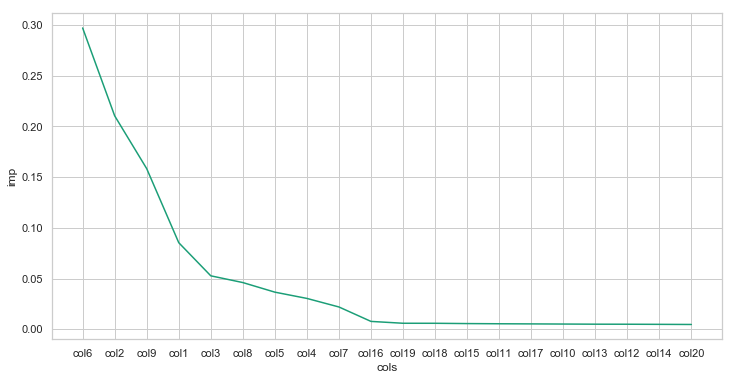

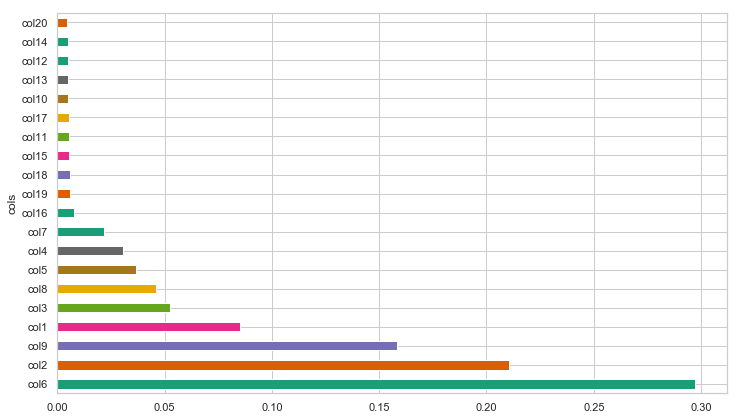

In [67]:
plot_feat_importance(fi)

Based on this, we can see there are a few features that stand out as being more important than the rest

Let's remove the other columns and generate new training and validation sets

In [68]:
df_keep = select_features(df, fi, threshold='mean')
df_keep.shape

(10000, 5)

In [69]:
df_keep.head()

,col6,col2,col9,col1,col3
0,-0.449087,2.690969,-3.398872,1.748267,-0.762359
1,-0.383794,2.897283,-3.319302,2.089446,-0.347177
2,-0.764300,1.124433,-1.811808,1.359057,-0.449752
3,-0.655792,-0.076773,-0.129660,0.942504,0.246008
4,-0.917844,1.796803,-3.348680,1.076313,-1.741340


Let's create new training and validation sets and repeat our test

In [70]:
X_train, X_val = split_vals(df_keep, n_train)

m = RandomForestClassifier(n_estimators=30, n_jobs=-1, min_samples_leaf=3, oob_score=True)
train_classifier(m, X_train, y_train)
predict_and_evaluate_classifier(m, X_val, y_val);

Accuracy (Training): 0.983125
          OOB Score: 0.9685
     Accuracy score: 0.90950


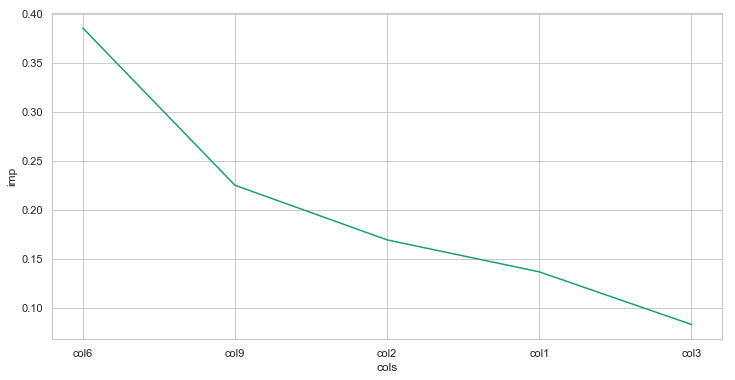

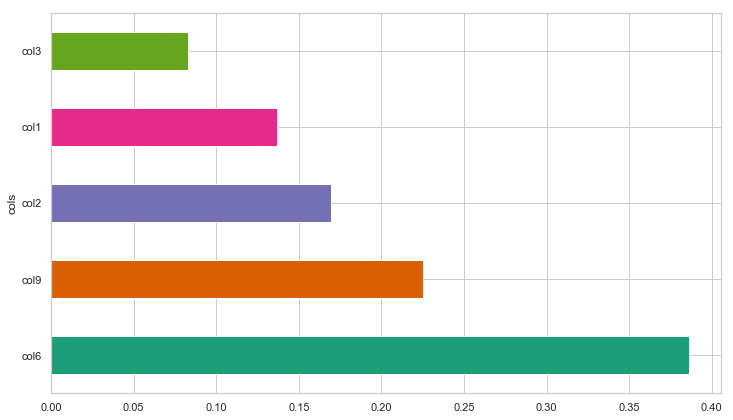

In [71]:
# let's look at the new feature importance
fi = rf_feat_importance(m, df_keep)
plot_feat_importance(fi);

## Redundant Features

In [741]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=10000,
                           n_features=20,
                           n_informative=3,
                           n_redundant=4,
                           n_repeated=2,
                           n_classes=2,
                           random_state=0,
                           shuffle=True)

# setup some columns names
x = np.arange(1, 21)
namer = lambda t: f"col{t}"
column_names = np.array([namer(xi) for xi in x])

# create a pandas dataframe as most of the mlutils functions expect it
df = pd.DataFrame(X, columns = column_names)
df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,0.390847,-0.152737,-0.097214,0.293592,-2.727677,3.583515,-0.675705,-0.037704,-1.093778,0.951373,0.682246,-0.777735,1.662753,3.583515,3.583515,-1.231099,-0.771200,-1.906944,0.018209,2.485197
1,1.407104,1.445306,0.201652,-0.348219,1.488090,-3.110413,0.423513,0.233638,-0.032394,0.881839,2.481651,0.176352,-0.950396,-3.110413,-3.110413,2.212725,1.260177,0.592770,0.808878,-0.591092
2,-0.701212,0.711910,0.146274,-0.626403,-0.953960,1.500152,-0.135463,-0.401058,-1.544397,-1.664982,-1.607283,-0.424453,0.157307,1.500152,1.500152,-1.303150,1.127975,-0.446372,-1.385937,0.184605
3,0.063452,-1.409879,0.030220,0.535491,1.294355,-2.039015,0.305151,3.075569,0.764420,-0.214244,-0.552891,-0.228569,-0.680151,-2.039015,-2.039015,1.188089,-0.085567,-1.187409,0.354629,-0.809087
4,-0.850707,-1.566191,0.464715,-1.766021,-0.539872,0.048967,0.109494,0.672569,1.551790,1.107491,0.006271,-0.379441,-0.511383,0.048967,0.048967,-0.385440,-0.260212,0.445383,-0.410527,-0.051890


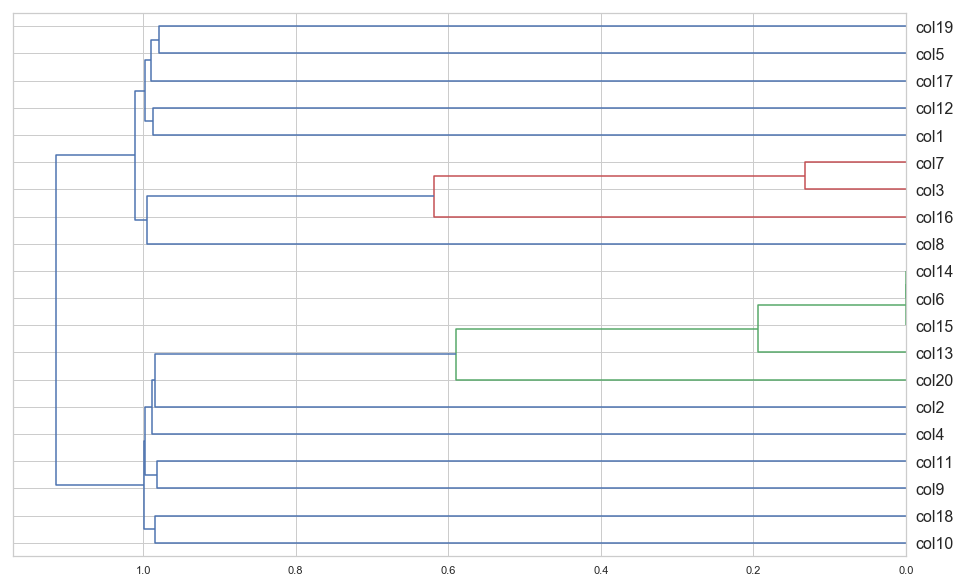

In [742]:
clusters, c_list = analyze_redundant_features(df, threshold=0.15, no_plot=False)

Looking at this, we can clearly identify a few redudant features by looking at how close to the right side they join up. This analysis clusters features together and measures distance between features and clusters.

The analyze_redundant_features also receives a threshold parameter that acts as a limit for distance. It returns a Dataframe with cluster and distance information for all aggregations under the threshold and an array of lists containing the groups of features that can be considered a group.

In [743]:
clusters

,a,b,distance
cluster,,,
cluster_0,col6,col14,0.000
cluster_1,col15,cluster_0,0.000
cluster_2,col3,col7,0.133


In [744]:
c_list

array([list(['col6', 'col14', 'col15']), list(['col3', 'col7'])],
      dtype=object)

Let's analyze the impact of removing these features to our OOB score

In [745]:
X_train, X_val = split_vals(df, n_train)
y_train, y_val = split_vals(y, n_train)

# get a baseline
m = RandomForestClassifier(n_estimators=30, n_jobs=-1, min_samples_leaf=3, oob_score=True)
train_classifier(m, X_train, y_train)
predict_and_evaluate_classifier(m, X_val, y_val);

Accuracy (Training): 0.985125
          OOB Score: 0.959875
     Accuracy score: 0.95250


In [746]:
f_list = np.concatenate(c_list)
analyze_single_feature_removal(m, df, y, f_list, metric='oob')

Baseline - 0.9585
------------------------------
col6 - 0.9572 (-0.0013)
col14 - 0.9568 (-0.0017)
col15 - 0.9587 (0.0002)
col3 - 0.9581 (-0.0004)
col7 - 0.9583 (-0.0002)


We should't remove all features, but rather remove all but one from each cluster

In [748]:
# this might be dangerous to do blindly, but works in this scenario
to_drop = np.array([])
for c in c_list:
    to_drop = np.append(to_drop, (np.random.choice(c,len(c)-1, replace=False)))

analyze_multiple_feature_removal(m, df, y, to_drop, metric='oob')

print("\nto_drop", to_drop)

Baseline - 0.9575
------------------------------
Result - 0.9564 (-0.0011)

to_drop ['col15' 'col14' 'col7']


oob_score varies significantly, but looking at oob_score, even it slightly lower, can still mean it's a good idea to remove them because we're building a more generalized model.

We can also look at the features from an accuracy impact perspective

In [749]:
analyze_single_feature_removal(m, df, y, f_list, metric='accuracy', val_data=(X_val, y_val))

Baseline - 0.978
------------------------------
col6 - 0.98 (0.002)
col14 - 0.979 (0.001)
col15 - 0.9805 (0.0025)
col3 - 0.979 (0.001)
col7 - 0.9785 (0.0005)


In [750]:
analyze_multiple_feature_removal(m, df, y, to_drop, metric='accuracy', val_data=(X_val, y_val))

Baseline - 0.9785
------------------------------
Result - 0.9795 (0.001)


## Extrapolation

Sometimes, the validation set has some unique aspects to it, which makes it difficult to train a model that performs well on that data. This happens tipically when the validation set is not a random sample of traning data. 

In many datasets that have a time series component, we usually want to predict the future, so our validation data should have the same temporal window of what we want our prediction to be. This causes some features like dates to be very different.

Also, if there is some trend that happens over time, like an increase of sales, any tree based approach can completely fail to predict future values if they are bigger than anything we saw in the past. In that case, we need to use gradient boosted trees to correctly model it.

In other cases, there are features which display a different distribution between training and validation data. These need to be dealt with, but we first need to identify it.